In [2]:
# Setup
import pandas as pd
import numpy as np
import git
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, sampler
import torchvision.transforms as T
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir
dtype=torch.float32

from barebone import *
from model_util import *

USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

/home/ubuntu/anaconda3/envs/cs231n/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load OpenPose Data

In [3]:
keypoints = np.load("{}/data/all_keypoints.npy".format(homedir), allow_pickle=True)
keypoints[0]

array(['ESzlIzyO',
       array([[3.32047e+02, 3.98396e+02, 8.52781e-01, ..., 3.91341e+02,
               1.03356e+03, 8.47541e-01],
              [3.32040e+02, 3.98392e+02, 8.51686e-01, ..., 3.91345e+02,
               1.03357e+03, 8.46827e-01],
              [3.32055e+02, 3.98462e+02, 8.60609e-01, ..., 3.91352e+02,
               1.03357e+03, 8.41133e-01],
              ...,
              [3.21681e+02, 4.05430e+02, 9.21052e-01, ..., 3.98331e+02,
               1.03712e+03, 8.62005e-01],
              [3.21715e+02, 4.05454e+02, 9.22338e-01, ..., 3.98333e+02,
               1.03704e+03, 8.61394e-01],
              [3.28646e+02, 3.98296e+02, 8.48421e-01, ..., 3.87965e+02,
               1.03360e+03, 8.37185e-01]])                             ],
      dtype=object)

In [4]:
features_kp = np.zeros((383, 60*75 + 1), dtype=object)

In [5]:
# downsample the keypoints 
# each video has framerate = 30; take frames 30-89 to represent the second 2 seconds of each video
for i, subject in enumerate(keypoints): 
    subjectId = subject[0]
    kp = subject[1]
    
    features_kp[i, 0] = subjectId
    features_kp[i, 1:] = kp[30:90].flatten()

In [6]:
df_kp = pd.DataFrame(features_kp)
df_kp = df_kp.rename(columns={0: 'subjectid'})
df_kp

,subjectid,1,2,3,4,5,6,7,8,9,...,4491,4492,4493,4494,4495,4496,4497,4498,4499,4500
0,ESzlIzyO,335.63,405.249,0.895572,290.132,503.095,0.849572,262.146,513.397,0.86198,...,0.376569,509.991,1058.1,0.757028,485.627,1071.88,0.835966,401.921,1030.12,0.89212
1,zN0O4jLu,230.898,248.255,0.856856,318.156,353.015,0.853513,258.749,353.053,0.774952,...,0.668692,206.277,1155.67,0.775272,206.374,1138.38,0.647594,321.438,1113.89,0.63126
2,nM7tQcBS,436.93,84.2963,0.849167,381.013,182.025,0.892465,318.176,168.019,0.817223,...,0.805224,373.935,1030.18,0.754506,339.108,1026.63,0.706043,300.716,988.272,0.812182
3,OuYG4U64,541.525,321.646,0.933987,461.399,457.626,0.900076,408.853,454.199,0.844952,...,0.879541,440.289,1075.43,0.846009,408.952,1075.43,0.874136,363.458,1023.09,0.787195
4,tFSyXitq,607.894,267.412,0.94842,524.122,440.729,0.888483,388.191,440.546,0.783813,...,0.651009,524.325,1833.72,0.543139,471.893,1839.0,0.54514,419.543,1750.08,0.608088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378,bqTsXpKl,276.187,471.733,0.84257,332.062,548.464,0.86469,272.7,548.481,0.871379,...,0.717557,206.472,1047.57,0.862025,206.464,1037.14,0.770676,297.223,1005.69,0.775751
379,UDXlpEgF,468.19,94.8551,0.782617,426.347,230.757,0.822717,373.862,206.547,0.822391,...,0.830474,387.972,908.085,0.88934,366.96,908.177,0.866333,332.044,876.437,0.79478
380,b632WDpF,644.923,141.884,0.908126,560.965,382.903,0.869544,429.859,382.861,0.741821,...,0.799335,602.817,1718.56,0.735241,560.778,1718.44,0.740828,492.83,1650.39,0.68736
381,ybGzWMPA,398.35,206.403,0.923946,352.968,297.207,0.897122,293.692,290.32,0.907,...,0.846899,349.699,918.397,0.831726,328.545,925.398,0.806425,293.832,904.335,0.782418


### Load Precalculated Features

In [7]:
# Create a numpy array containing all the calculated features from the original paper
# Exclude fields 0 (identifiers), 2 (orientation), 3 (framerate) and 537+ (survey data)
df_calc = pd.read_csv(r'https://raw.githubusercontent.com/amandaliusa/cs231n/main/data/dataClean_text.csv')
df_calc = df_calc.iloc[:,:537]
df_calc.drop(['X', 'orientation', 'framerate'], axis=1, inplace=True)
df_calc

,subjectid,n,time,time_diff,speed,time_sd,speed_sd,n_sit2stand,time_sit2stand,time_diff_sit2stand,...,neck_max_y_acc_stand2sit,ank_to_hip_dist_sit,ank_to_hip_dist_stand,knee_to_hip_dist_sit,knee_to_hip_dist_stand,height,lknee_angle_first_sit,rknee_angle_first_sit,lknee_angle_first_stand,rknee_angle_first_stand
0,kGhQ1FQc,5,18.752067,-0.275275,0.27,0.631539,0.058177,5,5.972633,-1.618283,...,3.505124,1.081186,1.006474,1.221493,0.869235,0.974188,104.281728,130.765245,174.111505,170.157767
1,KyINSk8e,5,13.346667,-0.216883,0.37,0.395926,0.071269,5,4.337667,-1.101100,...,3.654509,1.057510,1.018101,0.979709,0.735422,0.949425,113.416249,122.046417,183.473800,170.403354
2,ybGzWMPA,5,9.175833,0.108442,0.54,0.152175,0.044839,5,4.304300,0.008342,...,4.730823,1.324459,1.407150,1.272274,1.064869,0.963154,110.360354,116.014708,154.888698,154.736858
3,b632WDpF,4,11.033333,0.133333,0.36,0.234965,0.031573,4,3.833333,-0.700000,...,3.772340,1.523048,1.506615,1.525126,1.145206,0.948291,359.999821,132.874089,179.434883,172.483812
4,UDXlpEgF,5,11.444767,-0.108442,0.44,0.225910,0.045701,5,4.471133,-0.600600,...,5.261429,1.017858,0.947927,0.879847,0.623896,0.993858,113.339615,115.098166,178.141457,171.161810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,tFSyXitq,5,10.066667,0.225000,0.50,0.344867,0.069775,5,4.800000,0.075000,...,4.927668,0.864066,0.852848,1.118739,0.830468,0.966577,94.484956,115.572113,176.582448,175.372981
401,OuYG4U64,5,10.477133,0.116783,0.48,0.178317,0.044853,5,4.771433,-0.150150,...,4.448819,1.151292,1.100129,1.012293,0.837304,0.965469,109.993607,106.238842,182.016620,166.714119
402,nM7tQcBS,5,5.366667,0.058333,0.93,0.082731,0.076364,5,2.633333,0.008333,...,6.866623,1.374656,1.467833,1.375480,1.147340,0.970511,92.538523,108.185109,167.608827,164.889848
403,zN0O4jLu,5,24.290933,0.075075,0.21,0.377854,0.016347,5,12.412400,0.241908,...,2.242874,0.871977,1.034409,0.565355,0.657769,0.962403,106.005854,96.882321,160.433369,152.676643


### Load Survey Data (labels)

In [8]:
df_survey = pd.read_csv(r'https://raw.githubusercontent.com/amandaliusa/cs231n/main/data/survey_data.csv')
df_survey

,subjectid,OA_check
0,kGhQ1FQc,1
1,KyINSk8e,0
2,ybGzWMPA,0
3,b632WDpF,0
4,UDXlpEgF,0
...,...,...
400,tFSyXitq,1
401,OuYG4U64,0
402,nM7tQcBS,0
403,zN0O4jLu,0


### Preprocessing 

- Create train/val/test sets
- Normalization
- Oversampling
- Hand-pick features

In [9]:
# join the dataframes by subjectId 
df_join = df_kp.set_index('subjectid').join(df_calc.set_index('subjectid'))
df_join = df_join.join(df_survey.set_index('subjectid')).astype('float32')
df_join

,1,2,3,4,5,6,7,8,9,10,...,ank_to_hip_dist_sit,ank_to_hip_dist_stand,knee_to_hip_dist_sit,knee_to_hip_dist_stand,height,lknee_angle_first_sit,rknee_angle_first_sit,lknee_angle_first_stand,rknee_angle_first_stand,OA_check
subjectid,,,,,,,,,,,,,,,,,,,,,
ESzlIzyO,335.630005,405.248993,0.895572,290.131989,503.095001,0.849572,262.145996,513.396973,0.861980,346.191986,...,0.831638,1.153598,0.657760,0.648148,0.962856,97.261581,99.249542,185.223724,181.791748,0.0
zN0O4jLu,230.897995,248.255005,0.856856,318.156006,353.015015,0.853513,258.748993,353.053009,0.774952,178.574997,...,0.871977,1.034409,0.565355,0.657769,0.962403,106.005852,96.882324,160.433365,152.676636,0.0
nM7tQcBS,436.929993,84.296303,0.849167,381.013000,182.024994,0.892465,318.175995,168.018997,0.817223,426.196991,...,1.374656,1.467833,1.375480,1.147340,0.970511,92.538521,108.185112,167.608826,164.889847,0.0
OuYG4U64,541.525024,321.645996,0.933987,461.398987,457.626007,0.900076,408.852997,454.199005,0.844952,440.260986,...,1.151292,1.100129,1.012293,0.837304,0.965469,109.993607,106.238846,182.016617,166.714127,0.0
tFSyXitq,607.893982,267.411987,0.948420,524.122009,440.729004,0.888483,388.191010,440.545990,0.783813,524.356995,...,0.864066,0.852848,1.118739,0.830468,0.966577,94.484955,115.572113,176.582443,175.372986,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bqTsXpKl,276.187012,471.733002,0.842570,332.062012,548.463989,0.864690,272.700012,548.481018,0.871379,248.317001,...,1.430404,1.485496,1.395664,1.191145,0.943775,100.105484,120.529755,174.666214,174.914749,0.0
UDXlpEgF,468.190002,94.855103,0.782617,426.346985,230.757004,0.822717,373.862000,206.546997,0.822391,370.494995,...,1.017858,0.947927,0.879847,0.623896,0.993858,113.339615,115.098167,178.141464,171.161804,0.0
b632WDpF,644.922974,141.884003,0.908126,560.965027,382.903015,0.869544,429.859009,382.860992,0.741821,555.565002,...,1.523048,1.506615,1.525126,1.145206,0.948291,359.999817,132.874084,179.434875,172.483810,0.0


#### Data validation 

In [10]:
# do a stratified split so that each dataset has the same proportion of OA=0 and OA=1
y = df_join['OA_check']

# set a random seed for reproducibility 
np.random.seed(42)

# split out test set from train/val
train_val_indices, test_indices = train_test_split(np.arange(len(df_join)), test_size=0.1, stratify=y)

# split out val set from train
train_ind, val_ind = train_test_split(np.arange(len(train_val_indices)), test_size=0.11111, stratify=y[train_val_indices])
train_indices = train_val_indices[train_ind]
val_indices = train_val_indices[val_ind]

In [11]:
# 383 examples 
NUM_TRAIN = len(train_indices)
NUM_VAL = len(val_indices)

train_data = df_join.iloc[train_indices]
val_data = df_join.iloc[val_indices]
test_data = df_join.iloc[test_indices]

In [12]:
# Check for number of OA positive and number of samples in the dataset
# Total - 94% OA=0, 6% OA=1
print(df_join.iloc[:,-1].count())  # 383
print(df_join.iloc[:,-1].sum())    # 24
class_counts = [df_join.iloc[:,-1].count() - df_join.iloc[:,-1].sum(), df_join.iloc[:,-1].sum()]

# Train set - This implies that if the model always predicts 0, it would have 94% training accuracy
print(train_data.iloc[:,-1].count())  # 305
print(train_data.iloc[:,-1].sum())    # 20

# Validation set - This implies that if the model always predicts 0, it would have 95% val accuracy
print(val_data.iloc[:,-1].count())  # 39
print(val_data.iloc[:,-1].sum())    # 2

# Test set - This implies that if the model always predicts 0, it would have 95% test accuracy
print(test_data.iloc[:,-1].count())  # 39
print(test_data.iloc[:,-1].sum())    # 2

383
24.0
305
20.0
39
2.0
39
2.0


#### Normalization

In [13]:
# compute mean and std of the features 
means = []
stds = []
for column in train_data.iloc[:,:-1]: # only use training set, and exclude last column, which has labels
    column_np = train_data[column].to_numpy()
    means.append(np.mean(column_np))
    stds.append(np.std(column_np))
    
# apply normalization
def transform(feature): 
    return (feature - means) / stds

#### Create dataloaders

In [14]:
# with normalization, no oversampling
train = CustomDataset(dataframe=train_data, transform=transform)
loader_train = DataLoader(train, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomDataset(dataframe=val_data, transform=transform)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=transform)
loader_test = DataLoader(test, batch_size=64)

In [15]:
for i, (data, labels) in enumerate(loader_train):
  print(data.shape, labels.shape)
  print(data,labels)
  break

torch.Size([64, 5033]) torch.Size([64])
tensor([[-0.0578, -0.1671,  0.1650,  ..., -0.5190, -0.1989, -0.3394],
        [-0.7831,  1.2025,  0.5733,  ..., -0.3292,  0.6783,  0.4540],
        [ 0.0852,  0.3559,  0.7940,  ..., -0.0145,  0.2056,  0.1028],
        ...,
        [ 0.3672, -0.4713,  0.2939,  ..., -0.1462,  0.1578,  0.5999],
        [ 1.3170,  0.5931,  0.5126,  ...,  0.1978, -0.6314, -0.0733],
        [-0.6357, -1.5582,  0.7866,  ...,  0.9612, -0.3318,  0.1913]]) tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])


#### Create a manually curated data set

In [16]:
df_join["time_sit2stand"]
potential_cols = df_join.filter(regex=(".*(time|speed|trunk).*")).columns.values
# for p in potential_cols:
#     print(p)
cols_manual = ['time_sit2stand',
'speed_sit2stand',
'time_sd_sit2stand',
'speed_sd_sit2stand',
'time_stand2sit',
'speed_stand2sit',
'time_sd_stand2sit',
'speed_sd_stand2sit',
'trunk_lean_range_mean',
'trunk_lean_sd',
'trunk_lean_max',
'trunk_lean_min',
'trunk_lean_ang_vel',
'trunk_lean_ang_acc',
'trunk_lean_max_ang_vel',
'trunk_lean_max_ang_acc',
'trunk_lean_min_ang_vel',
'trunk_lean_min_ang_acc',
'trunk_lean_range_mean_sit2stand',
'trunk_lean_sd_sit2stand',
'trunk_lean_max_sit2stand',
'trunk_lean_min_sit2stand',
'trunk_lean_ang_vel_sit2stand',
'trunk_lean_ang_acc_sit2stand',
'trunk_lean_max_ang_vel_sit2stand',
'trunk_lean_max_ang_acc_sit2stand',
'trunk_lean_min_ang_vel_sit2stand',
'trunk_lean_min_ang_acc_sit2stand',
'trunk_lean_range_mean_stand2sit',
'trunk_lean_sd_stand2sit',
'trunk_lean_max_stand2sit',
'trunk_lean_min_stand2sit',
'trunk_lean_ang_vel_stand2sit',
'trunk_lean_ang_acc_stand2sit',
'trunk_lean_max_ang_vel_stand2sit',
'trunk_lean_max_ang_acc_stand2sit',
'trunk_lean_min_ang_vel_stand2sit',
'trunk_lean_min_ang_acc_stand2sit',
'OA_check']
df_manual = df_join.loc[:,cols_manual]

In [17]:
# Create separate loader with manually selected columns

train_m = CustomDataset(dataframe=df_manual.iloc[:NUM_TRAIN+NUM_VAL])
loader_train_m = DataLoader(train_m, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val_m = CustomDataset(dataframe=df_manual.iloc[:NUM_TRAIN+NUM_VAL])
loader_val_m = DataLoader(val_m, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, NUM_TRAIN+NUM_VAL)))

test_m = CustomDataset(dataframe=df_manual.iloc[NUM_TRAIN+NUM_VAL:])
loader_test_m = DataLoader(test_m, batch_size=64)

#### Create dataloaders with upsampling 

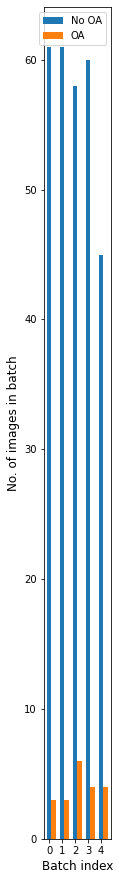

Avg Proportion of No OA per batch: 5.7
Avg Proportion of OA per batch: 0.4
Num. unique images seen: 304/305


In [18]:
train = CustomDataset(dataframe=train_data, transform=transform)
loader_train = DataLoader(train, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# visualize training data imbalance
_, _, _ = visualise_dataloader(loader_train, {0: "No OA", 1: "OA"})

In [19]:
train = CustomDataset(dataframe=train_data, transform=transform)
class_weights = 1./torch.tensor(class_counts, dtype=torch.float) 
labels = train_data.iloc[:,-1]
class_weights_all = class_weights[labels]

# oversample the training data 
weighted_sampler = sampler.WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)
loader_train_os = DataLoader(train, batch_size=64, sampler=weighted_sampler)

_, _, _ = visualise_dataloader(loader_train_os, {0: "No OA", 1: "OA"})

TypeError: 'float' object cannot be interpreted as an integer

#### Metrics for visualization

In [25]:
OA_negative = df_join.loc[df_join['OA_check']==0]

# Get average performance on a few key metrics for comparison
OA_negative_avg = OA_negative[['time_sit2stand','speed_sit2stand', 'time_stand2sit','speed_stand2sit','trunk_lean_range_mean','trunk_lean_max','trunk_lean_min',]].mean(axis=0)
OA_negative_std = OA_negative[['time_sit2stand','speed_sit2stand', 'time_stand2sit','speed_stand2sit','trunk_lean_range_mean','trunk_lean_max','trunk_lean_min',]].std(axis=0)
OA_negative_min = OA_negative[['time_sit2stand','speed_sit2stand', 'time_stand2sit','speed_stand2sit','trunk_lean_range_mean','trunk_lean_max','trunk_lean_min',]].min(axis=0)
OA_negative_max = OA_negative[['time_sit2stand','speed_sit2stand', 'time_stand2sit','speed_stand2sit','trunk_lean_range_mean','trunk_lean_max','trunk_lean_min',]].max(axis=0)


time_sit2stand            12.412400
speed_sit2stand            2.340000
time_stand2sit            14.014000
speed_stand2sit            2.560000
trunk_lean_range_mean     51.399803
trunk_lean_max           238.043655
trunk_lean_min           187.588470
dtype: float32

### BareBones Model

#### Train model with normalized inputs, no oversampling

In [19]:
train = CustomDataset(dataframe=train_data, transform=transform)
loader_train = DataLoader(train, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomDataset(dataframe=val_data, transform=transform)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=transform)
loader_test = DataLoader(test, batch_size=64)

input_size = 5033
hidden_size = 500
num_classes = 1
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train, loader_val, epochs=20)

Epoch 0, loss = 0.4463, train_acc = 93.4426, val_acc = 94.8718, train_pos = 0.0000, val_pos = 0.0000
Epoch 1, loss = 0.2196, train_acc = 93.4426, val_acc = 94.8718, train_pos = 0.0000, val_pos = 0.0000
Epoch 2, loss = 0.1549, train_acc = 93.7705, val_acc = 94.8718, train_pos = 0.3279, val_pos = 0.0000
Epoch 3, loss = 0.1985, train_acc = 94.0984, val_acc = 94.8718, train_pos = 0.6557, val_pos = 0.0000
Epoch 4, loss = 0.1788, train_acc = 94.0984, val_acc = 92.3077, train_pos = 0.6557, val_pos = 2.5641
Epoch 5, loss = 0.1006, train_acc = 95.0820, val_acc = 92.3077, train_pos = 1.6393, val_pos = 2.5641
Epoch 6, loss = 0.1372, train_acc = 95.7377, val_acc = 92.3077, train_pos = 2.2951, val_pos = 2.5641
Epoch 7, loss = 0.1100, train_acc = 95.4098, val_acc = 92.3077, train_pos = 1.9672, val_pos = 2.5641
Epoch 8, loss = 0.0909, train_acc = 95.7377, val_acc = 92.3077, train_pos = 2.2951, val_pos = 2.5641
Epoch 9, loss = 0.1035, train_acc = 97.0492, val_acc = 94.8718, train_pos = 3.6066, val_pos

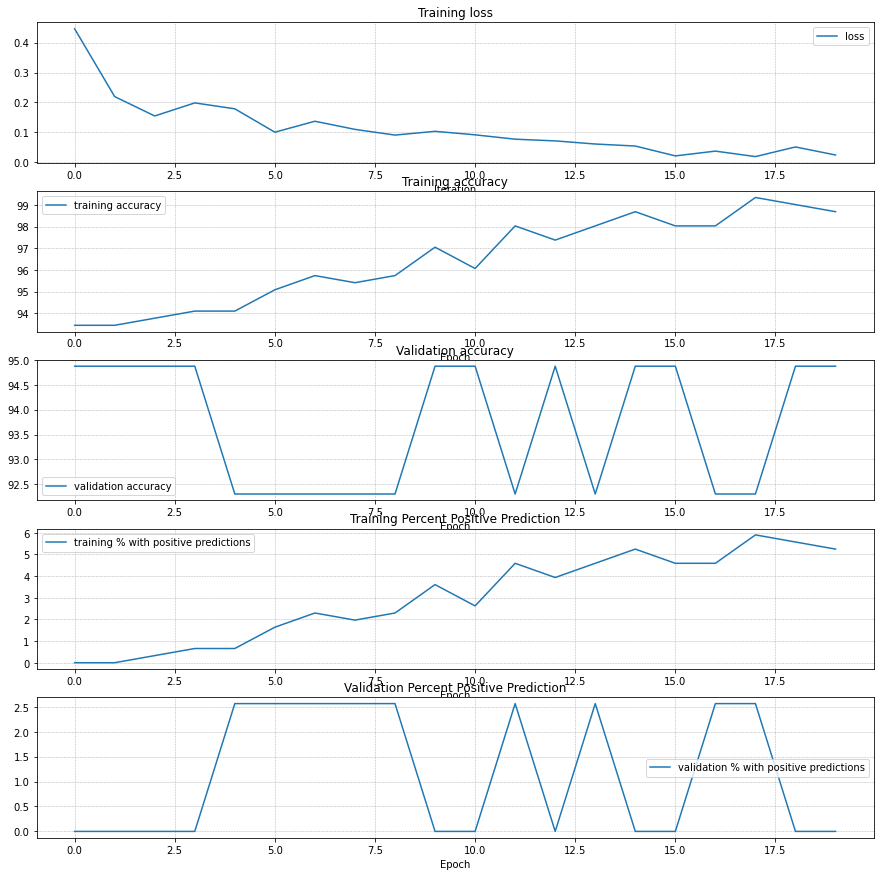

In [20]:
fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

#### Train model with normalized inputs on oversampled training set

In [21]:
train = CustomDataset(dataframe=train_data, transform=transform)
loader_train_os = DataLoader(train, batch_size=64, sampler=weighted_sampler)

val = CustomDataset(dataframe=val_data, transform=transform)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=transform)
loader_test = DataLoader(test, batch_size=64)

input_size = 5033
hidden_size = 500
num_classes = 1
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train_os, loader_val, epochs=50)

Epoch 0, loss = 0.5625, train_acc = 66.8852, val_acc = 79.4872, train_pos = 37.3770, val_pos = 15.3846
Epoch 1, loss = 0.3578, train_acc = 83.2787, val_acc = 89.7436, train_pos = 44.2623, val_pos = 5.1282
Epoch 2, loss = 0.4011, train_acc = 91.1475, val_acc = 92.3077, train_pos = 52.7869, val_pos = 2.5641
Epoch 3, loss = 0.2907, train_acc = 86.8852, val_acc = 87.1795, train_pos = 45.2459, val_pos = 7.6923
Epoch 4, loss = 0.2584, train_acc = 97.7049, val_acc = 87.1795, train_pos = 50.8197, val_pos = 7.6923
Epoch 5, loss = 0.1910, train_acc = 98.6885, val_acc = 89.7436, train_pos = 52.1311, val_pos = 5.1282
Epoch 6, loss = 0.1358, train_acc = 99.3443, val_acc = 89.7436, train_pos = 56.7213, val_pos = 5.1282
Epoch 7, loss = 0.1814, train_acc = 98.3607, val_acc = 92.3077, train_pos = 60.3279, val_pos = 2.5641
Epoch 8, loss = 0.1145, train_acc = 99.0164, val_acc = 92.3077, train_pos = 51.8033, val_pos = 2.5641
Epoch 9, loss = 0.1823, train_acc = 99.3443, val_acc = 89.7436, train_pos = 54.09

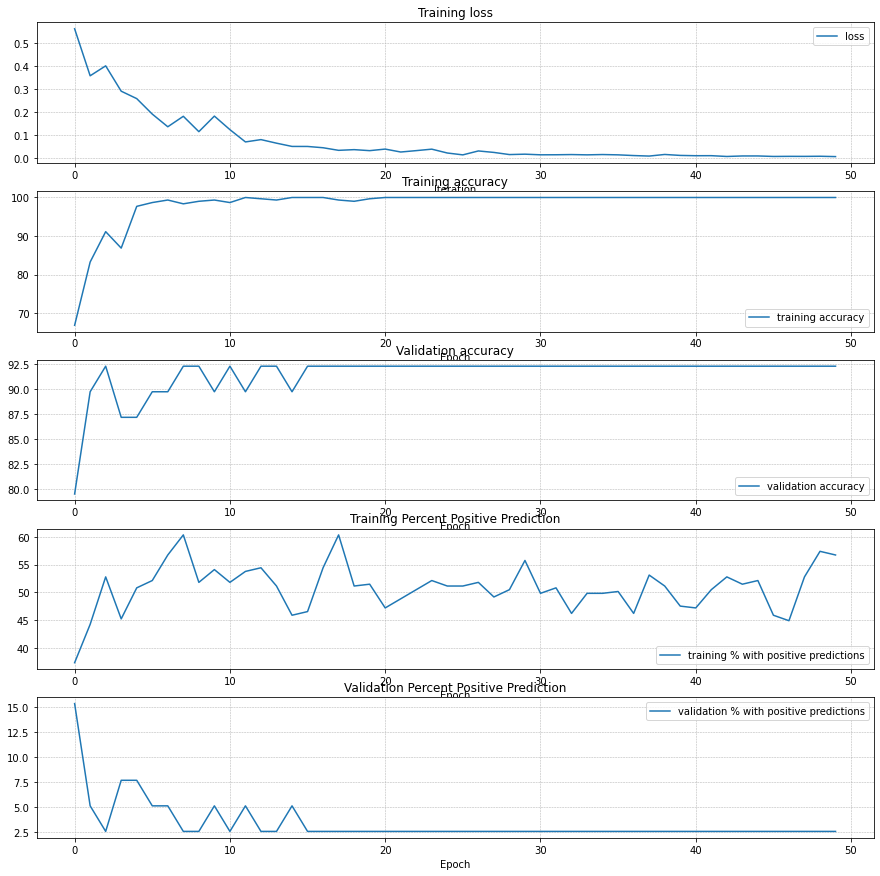

In [22]:
fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

#### Train model with normalized inputs, alternative oversampling 

In [23]:
# oversample the train/val data by increasing number of OA=1 and increasing overall dataset size
#train_val_data = pd.concat([train_data, val_data], axis=0)
index_0 = train_data.index[train_data['OA_check'] == 0.0].tolist()
class_0 = train_data.loc[index_0]
index_1 = train_data.index[train_data['OA_check'] == 1.0].tolist()
class_1 = train_data.loc[index_1]
class_count_0 = len(class_0)
class_1_over = class_1.sample(class_count_0, replace=True)
train_over = pd.concat([class_1_over, class_0], axis=0)
# shuffle the DataFrame rows
train_over = train_over.sample(frac = 1)

NUM_TRAIN_OS = len(train_over)

train = CustomDataset(dataframe=train_over, transform=transform)
loader_train_os2 = DataLoader(train, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN_OS)))

val = CustomDataset(dataframe=val_data, transform=transform)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=transform)
loader_test = DataLoader(test, batch_size=64)

input_size = 5033
hidden_size = 500
num_classes = 1
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train_os2, loader_val, epochs=50)

Epoch 0, loss = 0.5099, train_acc = 68.5965, val_acc = 89.7436, train_pos = 32.2807, val_pos = 5.1282
Epoch 1, loss = 0.2867, train_acc = 89.6491, val_acc = 92.3077, train_pos = 46.6667, val_pos = 2.5641
Epoch 2, loss = 0.2164, train_acc = 94.9123, val_acc = 89.7436, train_pos = 47.0175, val_pos = 5.1282
Epoch 3, loss = 0.1792, train_acc = 98.4211, val_acc = 92.3077, train_pos = 50.5263, val_pos = 2.5641
Epoch 4, loss = 0.1312, train_acc = 99.2982, val_acc = 92.3077, train_pos = 50.7018, val_pos = 2.5641
Epoch 5, loss = 0.1131, train_acc = 98.7719, val_acc = 92.3077, train_pos = 49.4737, val_pos = 2.5641
Epoch 6, loss = 0.0890, train_acc = 99.6491, val_acc = 92.3077, train_pos = 50.3509, val_pos = 2.5641
Epoch 7, loss = 0.0874, train_acc = 99.4737, val_acc = 92.3077, train_pos = 49.8246, val_pos = 2.5641
Epoch 8, loss = 0.0603, train_acc = 99.6491, val_acc = 92.3077, train_pos = 50.3509, val_pos = 2.5641
Epoch 9, loss = 0.0401, train_acc = 99.8246, val_acc = 92.3077, train_pos = 50.175

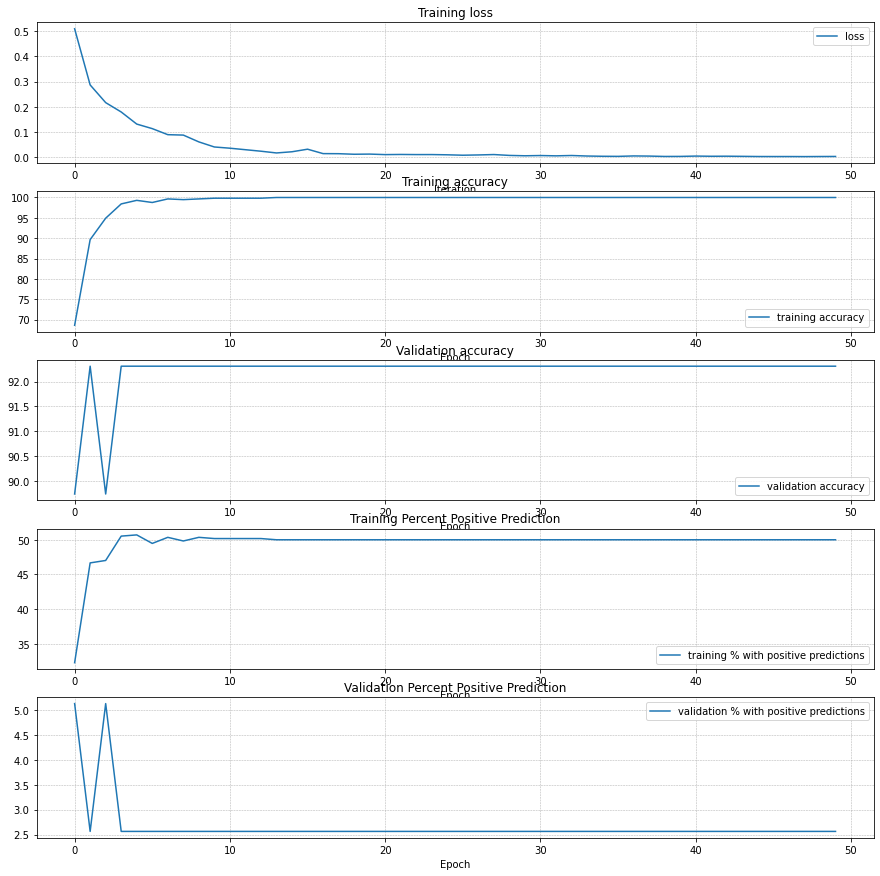

In [24]:
fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

#### Train model with unnormalized inputs, no oversampling

In [25]:
train = CustomDataset(dataframe=train_data)
loader_train = DataLoader(train, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomDataset(dataframe=val_data)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data)
loader_test = DataLoader(test, batch_size=64)

In [26]:
input_size = 5033
hidden_size = 500
num_classes = 1
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train, loader_val, epochs=50)

Epoch 0, loss = 153.6718, train_acc = 87.5410, val_acc = 94.8718, train_pos = 5.9016, val_pos = 0.0000
Epoch 1, loss = 12.7874, train_acc = 93.4426, val_acc = 94.8718, train_pos = 0.0000, val_pos = 0.0000
Epoch 2, loss = 10.7840, train_acc = 75.0820, val_acc = 94.8718, train_pos = 21.6393, val_pos = 0.0000
Epoch 3, loss = 24.2098, train_acc = 93.1148, val_acc = 94.8718, train_pos = 0.3279, val_pos = 0.0000
Epoch 4, loss = 2.8285, train_acc = 93.1148, val_acc = 94.8718, train_pos = 0.3279, val_pos = 0.0000
Epoch 5, loss = 20.5950, train_acc = 83.6066, val_acc = 89.7436, train_pos = 16.3934, val_pos = 5.1282
Epoch 6, loss = 10.0996, train_acc = 93.4426, val_acc = 94.8718, train_pos = 2.6230, val_pos = 0.0000
Epoch 7, loss = 7.5023, train_acc = 94.0984, val_acc = 94.8718, train_pos = 1.3115, val_pos = 0.0000
Epoch 8, loss = 3.2724, train_acc = 92.4590, val_acc = 53.8462, train_pos = 5.5738, val_pos = 41.0256
Epoch 9, loss = 7.5452, train_acc = 85.5738, val_acc = 94.8718, train_pos = 12.45

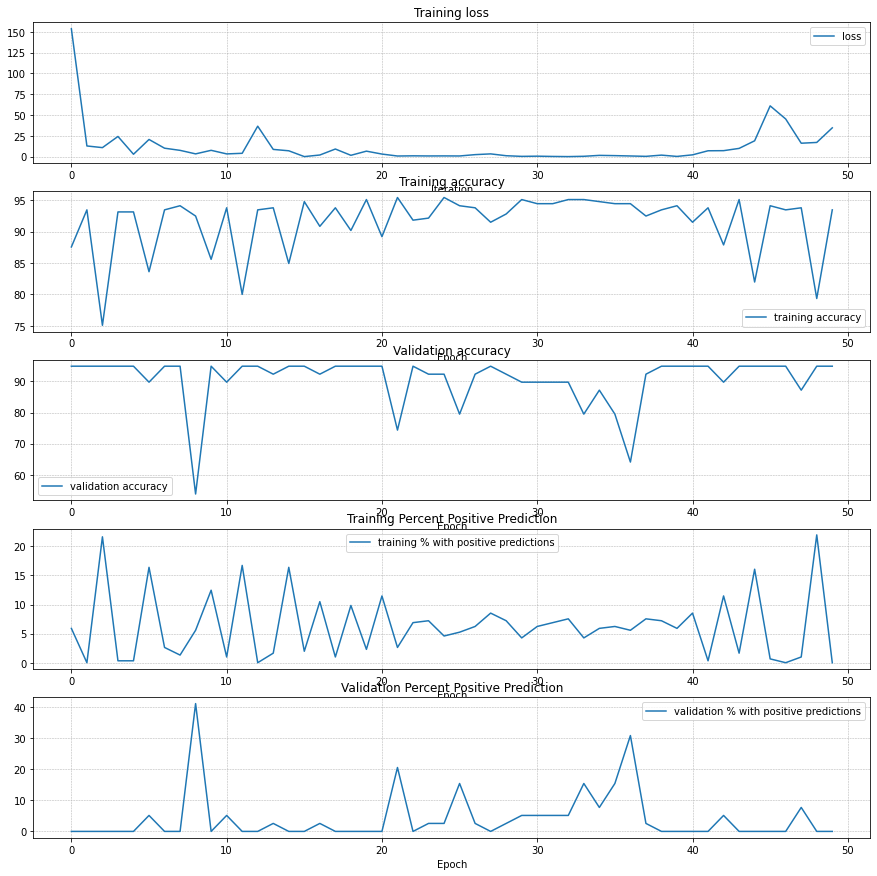

In [27]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

#### Train model with manually curated inputs, unnormalized

In [28]:
input_size = 38 
hidden_size = 20
num_classes = 1
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train_m, loader_val_m, epochs=50)

Epoch 0, loss = 107.4660, train_acc = 5.5738, val_acc = 7.6923, train_pos = 100.0000, val_pos = 100.0000
Epoch 1, loss = 101.0679, train_acc = 5.5738, val_acc = 7.6923, train_pos = 100.0000, val_pos = 100.0000
Epoch 2, loss = 89.9070, train_acc = 5.5738, val_acc = 7.6923, train_pos = 100.0000, val_pos = 100.0000
Epoch 3, loss = 87.8257, train_acc = 5.5738, val_acc = 7.6923, train_pos = 100.0000, val_pos = 100.0000
Epoch 4, loss = 78.4497, train_acc = 5.5738, val_acc = 7.6923, train_pos = 100.0000, val_pos = 100.0000
Epoch 5, loss = 79.1949, train_acc = 5.5738, val_acc = 7.6923, train_pos = 100.0000, val_pos = 100.0000
Epoch 6, loss = 65.6334, train_acc = 5.5738, val_acc = 7.6923, train_pos = 100.0000, val_pos = 100.0000
Epoch 7, loss = 62.2179, train_acc = 5.5738, val_acc = 7.6923, train_pos = 100.0000, val_pos = 100.0000
Epoch 8, loss = 53.4105, train_acc = 5.5738, val_acc = 7.6923, train_pos = 100.0000, val_pos = 100.0000
Epoch 9, loss = 45.4714, train_acc = 5.9016, val_acc = 7.6923,

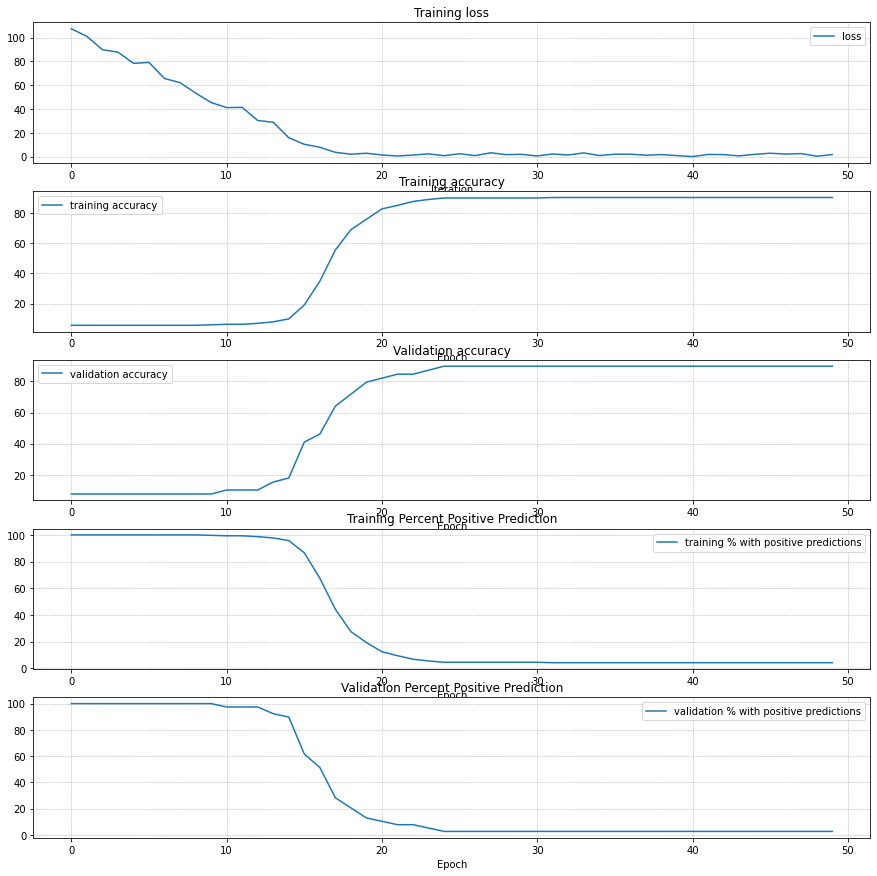

In [29]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

#### Train model with manually curated inputs, unnormalized, oversampled

In [30]:
train_manual = df_manual.iloc[:NUM_TRAIN+NUM_VAL]

index_0 = train_manual.index[train_manual['OA_check'] == 0.0].tolist()
class_0 = train_manual.loc[index_0]
index_1 = train_manual.index[train_manual['OA_check'] == 1.0].tolist()
class_1 = train_manual.loc[index_1]
class_count_0 = len(class_0)
class_1_over = class_1.sample(class_count_0, replace=True)
train_m_over = pd.concat([class_1_over, class_0], axis=0)
# shuffle the DataFrame rows
train_m_over = train_m_over.sample(frac = 1)

NUM_TRAIN_M_OS = len(train_m_over)

train_m = CustomDataset(dataframe=train_m_over)
loader_train_m = DataLoader(train_m, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN_M_OS)))

val_m = CustomDataset(dataframe=df_manual.iloc[:NUM_TRAIN+NUM_VAL])
loader_val_m = DataLoader(val_m, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, NUM_TRAIN+NUM_VAL)))

test_m = CustomDataset(dataframe=df_manual.iloc[NUM_TRAIN+NUM_VAL:])
loader_test_m = DataLoader(test_m, batch_size=64)

input_size = 38 
hidden_size = 20
num_classes = 1
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train_m, loader_val_m, epochs=100)

Epoch 0, loss = 0.7947, train_acc = 51.5432, val_acc = 58.9744, train_pos = 43.8272, val_pos = 38.4615
Epoch 1, loss = 0.3602, train_acc = 48.3025, val_acc = 23.0769, train_pos = 36.5741, val_pos = 84.6154
Epoch 2, loss = 0.9902, train_acc = 54.4753, val_acc = 46.1538, train_pos = 50.7716, val_pos = 51.2821
Epoch 3, loss = 1.3308, train_acc = 51.0802, val_acc = 74.3590, train_pos = 46.4506, val_pos = 17.9487
Epoch 4, loss = 1.0152, train_acc = 48.1481, val_acc = 76.9231, train_pos = 36.4198, val_pos = 15.3846
Epoch 5, loss = 1.2361, train_acc = 54.3210, val_acc = 71.7949, train_pos = 42.2840, val_pos = 20.5128
Epoch 6, loss = 1.0486, train_acc = 55.8642, val_acc = 79.4872, train_pos = 42.2840, val_pos = 12.8205
Epoch 7, loss = 0.7294, train_acc = 54.7840, val_acc = 71.7949, train_pos = 38.4259, val_pos = 20.5128
Epoch 8, loss = 0.9365, train_acc = 55.7099, val_acc = 71.7949, train_pos = 40.8951, val_pos = 20.5128
Epoch 9, loss = 0.5088, train_acc = 57.0988, val_acc = 69.2308, train_pos

Epoch 79, loss = 0.5795, train_acc = 70.0617, val_acc = 76.9231, train_pos = 38.8889, val_pos = 20.5128
Epoch 80, loss = 0.9210, train_acc = 69.4444, val_acc = 71.7949, train_pos = 39.1975, val_pos = 25.6410
Epoch 81, loss = 0.4228, train_acc = 70.6790, val_acc = 79.4872, train_pos = 39.5062, val_pos = 17.9487
Epoch 82, loss = 0.4104, train_acc = 70.3704, val_acc = 61.5385, train_pos = 37.3457, val_pos = 46.1538
Epoch 83, loss = 0.5593, train_acc = 68.3642, val_acc = 92.3077, train_pos = 49.8457, val_pos = 0.0000
Epoch 84, loss = 0.3976, train_acc = 60.4938, val_acc = 58.9744, train_pos = 33.3333, val_pos = 48.7179
Epoch 85, loss = 0.4569, train_acc = 68.9815, val_acc = 74.3590, train_pos = 46.7593, val_pos = 28.2051
Epoch 86, loss = 0.9285, train_acc = 70.5247, val_acc = 82.0513, train_pos = 42.1296, val_pos = 15.3846
Epoch 87, loss = 0.4607, train_acc = 65.1235, val_acc = 87.1795, train_pos = 33.6420, val_pos = 10.2564
Epoch 88, loss = 0.1291, train_acc = 69.9074, val_acc = 74.3590, 

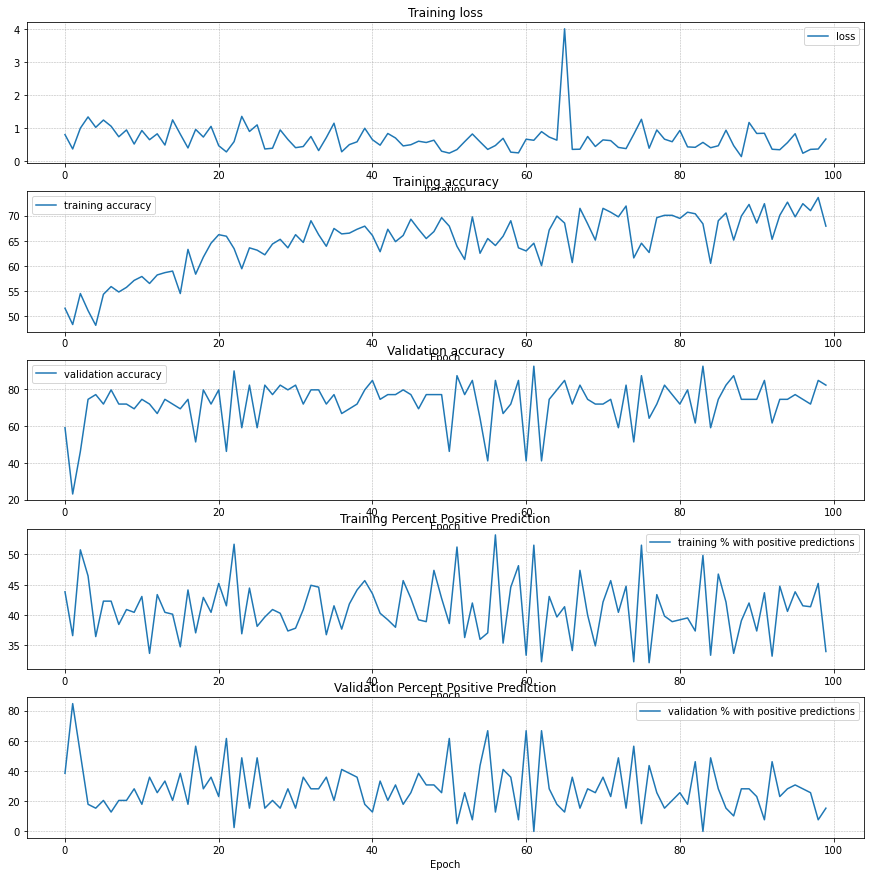

In [31]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

In [32]:
# Placeholder for model visualization